In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import random

Using matplotlib backend: Qt5Agg


In [2]:
import gillespy2
from gillespy2.basic_root_solver import BasicRootSolver
from gillespy2.basic_ssa_solver import BasicSSASolver
from gillespy2.basic_hybrid_solver import BasicHybridSolver

Unable to use Cython optimized SSA:
Error:Building module gillespy2.cython_ssa_solver failed: ['distutils.errors.DistutilsPlatformError: Unable to find vcvarsall.bat\n']


In [3]:
class MichaelisMenten(gillespy2.Model):
     def __init__(self, parameter_values=None):
            #initialize Model
            gillespy2.Model.__init__(self, name="Michaelis_Menten")
            
            #parameters
            rate1 = gillespy2.Parameter(name='rate1', expression= 0.000017)
            rate2 = gillespy2.Parameter(name='rate2', expression= 0.005)
            rate3 = gillespy2.Parameter(name='rate3', expression = 0.001)
            self.add_parameter([rate1,rate2,rate3])
            
            #rate_rules
            rate_rule1 = gillespy2.RateRule(name='rate_rule1', expression = "math.sin(t)")
            self.add_rate_rule(rate_rule1)
            
            #Species
            A = gillespy2.Species(name='A', initial_value=100)
            B = gillespy2.Species(name='B', initial_value=100)
            C = gillespy2.Species(name='C', initial_value=100)
            D = gillespy2.Species(name='D', initial_value=100)
            #DET = gillespy2.Species(name='DET', initial_value=1) #Create a deterministic species
            #Deterministic species will be a regular species, but with "deterministic" flag
            DET = gillespy2.Species(name='DET', initial_value=1, deterministic=True, rate_rule=rate_rule1)
            self.add_species([A, B, C, D, DET])
            
            #reactions
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={C:1},
                   rate=rate1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={C:1}, products={A:1,B:1},
                    rate=rate2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={C:1}, products={B:1,D:1},
                    rate=rate3)
            r4 = gillespy2.Reaction(name="r4", propensity_function="rate2*A*DET/vol")
            #r4 uses a deterministic species result as an argument
            self.add_reaction([r1,r2,r3, r4])
            self.timespan(numpy.linspace(0,100,101))

In [4]:
model = MichaelisMenten()

In [5]:
def func(y, t, pops, species, parameters, reactions, rate_rules):
    curr_state = {'vol':1}
    state_change = []
    for i, s in enumerate(species):
        curr_state[s] = pops[i]
        if model.listOfSpecies[s].deterministic:
            curr_state[s] = y[i]
    #curr_state['DET'] = y[4] #Override population for deterministic species with current pop
    #this will require knowing the index of the deterministic species in y
    for p in parameters:
        curr_state[p] = parameters[p].value
    for i, r in enumerate(reactions):
        state_change.append(eval(reactions[r].propensity_function, curr_state))
    for i, rr in enumerate(rate_rules):
        state_change.append(eval(rate_rules[rr].expression))
    #state_change.append(eval("math.sin(t)"))  #This is the deterministic rate (RateRules) to append in a loop
    return state_change

In [6]:
for i, r in enumerate(model.listOfReactions):
    print(model.listOfReactions[r].propensity_function)
for i, rr in enumerate(model.listOfRateRules):
    print(model.listOfRateRules[rr].expression)

rate1*A*B/vol
rate2*C
rate3*C
rate2*A*DET/vol
math.sin(t)


In [7]:
t = numpy.linspace(0, .1, 11)
num_deterministic = 0
for i, s in enumerate(model.listOfSpecies):
    if model.listOfSpecies[s].deterministic:
        num_deterministic += 1
y0 = [0] * (len(model.listOfReactions)+num_deterministic) # +1 for deterministic species
#HERE, we will add +num_det_species which will be collected at species creation
populations = []
propensities = {}
curr_state = {}
curr_time = 0
curr_state['vol'] = 1
save_time = 0
end_time = t[-1]
results = {'time': []}
test_count = 0


for s in model.listOfSpecies:
    # initialize populations
    populations.append(model.listOfSpecies[s].initial_value)
    curr_state[s] = model.listOfSpecies[s].initial_value
    results[s] = []

for p in model.listOfParameters:
    curr_state[p] = model.listOfParameters[p].value

#print(curr_time)
#print(end_time)
#while curr_time < end_time:
test_count += 1
propensity_sum = 0
for i, r in enumerate(model.listOfReactions):
    y0[i] = (math.log(random.uniform(0, 1)))
    propensities[r] = eval(model.listOfReactions[r].propensity_function, curr_state)
    propensity_sum += propensities[r]
#y0[4] = 1 #Get value of deterministic species
#First time, sets to initial value, after that...curr_state? 
#This would be a for loop capturing all deterministic species
for i, s in enumerate(model.listOfSpecies):
    if model.listOfSpecies[s].deterministic:
        y0[i] = curr_state[s]
if propensity_sum <= 0:
    while save_time <= end_time:
        results['time'].append(save_time)
        for s in model.listOfSpecies:
            results[s].append(curr_state[s])
        save_time += increment

In [8]:
print(y0)
t2= numpy.linspace(0, 10, 101)

[-0.5535725952886762, -0.45869068124381174, -0.16781891204225652, -0.4744414890864605, 1]


In [9]:
y = odeint(func, y0, t2, args=(populations, model.listOfSpecies, model.listOfParameters, model.listOfReactions, model.listOfRateRules))

In [10]:
rx1 = y[:,0]
rx2 = y[:,1]
rx3 = y[:,2]
rx4 = y[:,3] # Reaction including Deterministic Species
det = y[:,4] # Determinisitc Species

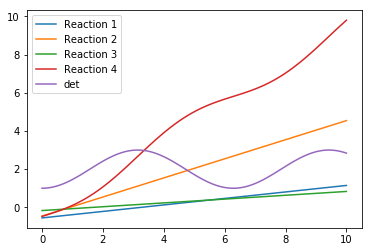

In [11]:
plt.plot(t2, rx1, label="Reaction 1")
plt.plot(t2, rx2, label="Reaction 2")
plt.plot(t2, rx3, label="Reaction 3")
plt.plot(t2, rx4, label="Reaction 4")
plt.plot(t2, det, label="det")
plt.legend(loc="best")

In [12]:
results = model.run(solver=BasicHybridSolver(), show_labels=True)
print(results)

['r4', 0.007802333168008624]
['r3', 0.12241745233948931]
['r1', 1.2108005382527804]
['r4', 0.45969769794480786]
['r2', 0.12241745233948931]
['r2', 1.416145477130298]
['r2', 0.12241745233948932]
['r2', 1.4161454771302975]
['r3', 1.4161454771302975]
['r1', 0.45969769794480786]
['r4', 1.4161454771302975]
['r4', 0.12241745233948932]
['r4', 0.9292623646634561]
['r4', 0.22716519704707078]
['r2', 1.4161454771302975]
['r2', 0.007802333168008624]
['r1', 0.2683111623819755]
['r4', 1.0541765896051334]
['r1', 1.9899917172237502]
['r2', 1.4161454771302975]
['r4', 0.45969769794480797]
['r2', 1.4161454771302975]
['r4', 0.0310875813335248]
['r4', 1.4161454771302975]
['r4', 0.17115171252592062]
['r2', 1.6536494924796663]
['r2', 0.12241745233948931]
['r4', 1.4161454771303015]
['r1', 1.4161454771302975]
['r2', 0.12241745233948931]
['r2', 1.4161454771302975]
['r4', 1.4161454771302975]
['r2', 0.12241745233948935]
['r1', 0.12241745233948932]
['r4', 0.12241745233948931]
['r2', 1.4161454771303015]
['r4', 0.00

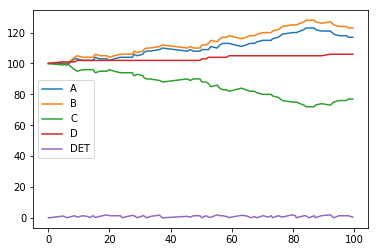

In [13]:
plt.plot(results['time'], results['A'], label='A')
plt.plot(results['time'], results['B'], label='B')
plt.plot(results['time'], results['C'], label='C')
plt.plot(results['time'], results['D'], label='D')
plt.plot(results['time'], results['DET'], label='DET')
plt.legend(loc='best')

In [14]:
results1 = model.run(solver=BasicRootSolver(), show_labels=True)

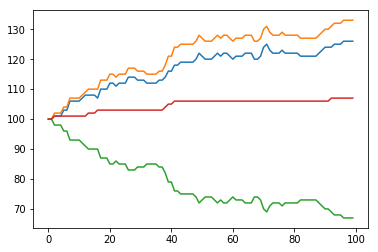

In [15]:
plt.plot(results1['time'], results1['A'])
plt.plot(results1['time'], results1['B'])
plt.plot(results1['time'], results1['C'])
plt.plot(results1['time'], results1['D'])